In [1]:
# Include libraries.
import paddle
import paddle.fluid as fluid
import numpy
import math
import sys
from __future__ import print_function

# import matplotlib.pyplot as plt
# import matplotlib
# matplotlib.use('Agg')


In [2]:
SAVE_DIRNAME = 'models_'

In [3]:
# Plot data
from paddle.utils.plot import Ploter
train_prompt = "Train cost"
test_prompt = "Test cost"
plot_prompt = Ploter(train_prompt, test_prompt)# For training test cost


In [4]:
def train_test(executor, program, reader, feeder, fetch_list):
    accumulated = 1 * [0]
    count = 0
    for data_test in reader():
        outs = executor.run(program=program,
                            feed=feeder.feed(data_test),
                            fetch_list=fetch_list)
        accumulated = [x_c[0] + x_c[1][0] for x_c in zip(accumulated, outs)]
        count += 1
    return [x_d / count for x_d in accumulated]

In [5]:
# 输入输入层和标签层
x = fluid.layers.data(name='x', shape=[13], dtype='float32')

# 定义网络
y_predict = fluid.layers.fc(input=x, size=1, act=None)

y = fluid.layers.data(name='y', shape=[1], dtype='float32')

cost = fluid.layers.square_error_cost(input=y_predict, label=y)
avg_cost = fluid.layers.mean(cost)

# 定义优化器
sgd_optimizer = fluid.optimizer.SGD(learning_rate=0.001)
sgd_optimizer.minimize(avg_cost)


# 定义batch
train_reader = paddle.batch(
    paddle.reader.shuffle(paddle.dataset.uci_housing.train(), buf_size=500),
    batch_size=20)

# 定义场所
place = fluid.CPUPlace() # fluid.CUDAPlace(0)
exe = fluid.Executor(place)


/usr/local/lib/python2.7/dist-packages/paddle/dataset/uci_housing.py:49: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 499, in start
    self.io_loop.start()
  File "/usr/local/lib/python2.7/d

In [6]:
# 输入输入层和标签层
x = fluid.layers.data(name='x', shape=[13], dtype='float32')

# 定义网络
y_predict = fluid.layers.fc(input=x, size=1, act=None)

y = fluid.layers.data(name='y', shape=[1], dtype='float32')

cost = fluid.layers.square_error_cost(input=y_predict, label=y)
avg_cost = fluid.layers.mean(cost)

# 定义优化器
sgd_optimizer = fluid.optimizer.SGD(learning_rate=0.001)
sgd_optimizer.minimize(avg_cost)

test_program = fluid.default_main_program().clone(for_test=True)

# 定义batch
train_reader = paddle.batch(
    paddle.reader.shuffle(paddle.dataset.uci_housing.train(), buf_size=500),
    batch_size=20)

test_reader = paddle.batch(
    paddle.reader.shuffle(paddle.dataset.uci_housing.test(), buf_size=500),
    batch_size=2)


# 定义场所
place = fluid.CPUPlace() # fluid.CUDAPlace(0)
exe = fluid.Executor(place)


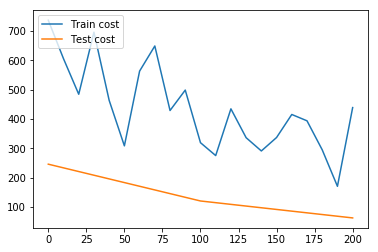

<Figure size 432x288 with 0 Axes>

In [7]:



def train_loop():
    feeder = fluid.DataFeeder(place=place, feed_list=[x, y])
    exe.run(fluid.default_startup_program())
    step = 0
    exe_test = fluid.Executor(place)

    
    PASS_NUM = 10
    for pass_id in range(PASS_NUM):
        total_loss_pass = 0
        for data in train_reader():
            avg_loss_value, = exe.run(
                fluid.default_main_program(), 
                feed=feeder.feed(data), 
                fetch_list=[avg_cost])
            total_loss_pass += avg_loss_value
            ####### 画图开始
            if step % 10 == 0:  # record a train cost every 10 batches
                plot_prompt.append(train_prompt, step, avg_loss_value[0])
                plot_prompt.plot()
            if step % 100 == 0:  # record a test cost every 100 batches
                test_metics = train_test(executor=exe_test,
                                         program=test_program,
                                         reader=test_reader,
                                         fetch_list=[avg_cost.name],
                                         feeder=feeder)
                plot_prompt.append(test_prompt, step, test_metics[0])
                plot_prompt.plot()
                # If the accuracy is good enough, we can stop the training.
#                 if test_metics[0] < 10.0:
#                     return 
            step += 1
            ######## 画图结束
            if math.isnan(float(avg_loss_value[0])):
                sys.exit("got NaN loss, training failed.")    


            if avg_loss_value <1.0:
                if SAVE_DIRNAME is not None:
                    fluid.io.save_inference_model(
                        SAVE_DIRNAME, ['x'], [y_predict], exe)
#                 return
#         print("Pass %d, total avg cost = %f" % (pass_id, total_loss_pass))

train_loop()

In [8]:

place = fluid.CPUPlace()
exe = fluid.Executor(place)

inference_scope = fluid.core.Scope()
with fluid.scope_guard(inference_scope):
    [inference_program, feed_target_names, fetch_targets] = (
        fluid.io.load_inference_model(SAVE_DIRNAME, exe))
    test_reader = paddle.batch(paddle.dataset.uci_housing.test(), batch_size=20)

    test_data = test_reader().next()
    test_feat = numpy.array(map(lambda x: x[0], test_data)).astype("float32")
    test_label = numpy.array(map(lambda x: x[1], test_data)).astype("float32")
    print(feed_target_names[0])
    results = exe.run(inference_program,
                      feed={feed_target_names[0]: numpy.array(test_feat)},
                      fetch_list=fetch_targets)
    print("infer results: ", results[0])
    print("ground truth: ", test_label)

x
infer results:  [[13.028505 ]
 [13.27338  ]
 [12.973402 ]
 [13.882124 ]
 [13.2918   ]
 [13.662638 ]
 [13.631207 ]
 [13.248424 ]
 [12.019205 ]
 [13.340189 ]
 [11.608441 ]
 [12.432707 ]
 [12.782322 ]
 [12.62546  ]
 [12.8106575]
 [13.021822 ]
 [13.677567 ]
 [13.598593 ]
 [14.043578 ]
 [13.059525 ]]
ground truth:  [[ 8.5]
 [ 5. ]
 [11.9]
 [27.9]
 [17.2]
 [27.5]
 [15. ]
 [17.2]
 [17.9]
 [16.3]
 [ 7. ]
 [ 7.2]
 [ 7.5]
 [10.4]
 [ 8.8]
 [ 8.4]
 [16.7]
 [14.2]
 [20.8]
 [13.4]]
